In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_app_train = pd.read_csv('../data/raw/application_train.csv')
df_app_test  = pd.read_csv('../data/raw/application_test.csv')

df_bureau = pd.read_csv('../data/raw/bureau.csv')
df_bureau_balance = pd.read_csv('../data/raw/bureau_balance.csv')

df_prev_app = pd.read_csv('../data/raw/previous_application.csv')
df_pos_cash = pd.read_csv('../data/raw/POS_CASH_balance.csv')
df_installments = pd.read_csv('../data/raw/installments_payments.csv')
df_cc_balance = pd.read_csv('../data/raw/credit_card_balance.csv')

In [3]:
df_app_train.shape

(307511, 122)

The application_train table contains 307,511 rows and 122 features,
where each row represents a unique loan application.

In [4]:
df_app_train['SK_ID_CURR'].is_unique

True

SK_ID_CURR is unique in application_train, confirming that the dataset
is already at the correct modeling granularity.

In [5]:
df_app_train.isna().mean().sort_values(ascending=False).head(10)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
dtype: float64

A large number of housing-related variables (e.g. COMMONAREA, LIVINGAPARTMENTS)
exhibit very high missing rates (around 70%). This pattern suggests that the
missingness is likely structural or business-related, rather than random.
For example, applicants without registered housing information naturally lack
these attributes. Therefore, such missing values may carry predictive meaning
and should be treated carefully during feature engineering.

In [6]:
df_app_train['DAYS_EMPLOYED'].value_counts().head()

DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

The variable DAYS_EMPLOYED shows an abnormal value of 365243, which appears
far more frequently than any other value. This value is a known placeholder
used in the Home Credit dataset to indicate applicants without a formal
employment history. Therefore, this value should not be treated as a real
employment duration but rather as a separate category or missing indicator
during feature engineering.

In [7]:
df_app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

The variable DAYS_BIRTH is expressed as a negative number representing
the number of days before the application date. Its range corresponds
to a realistic age distribution (approximately 20 to 70 years),
indicating that this variable is well-behaved and does not contain
obvious anomalies.

In [27]:
time_cols = [c for c in df_app_train.columns if c.startswith("DAYS_") or c.startswith("HOUR_") or c.startswith("WEEKDAY_")]
time_cols

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'DAYS_LAST_PHONE_CHANGE']

## Time-related Fields

Many time variables are encoded as offsets relative to the application date.
- `DAYS_*`: typically negative values representing days **before** the application date (e.g., `DAYS_BIRTH`).
- `HOUR_APPR_PROCESS_START`: hour of the day when application process started.
- `WEEKDAY_APPR_PROCESS_START`: weekday of application start.

These fields require careful handling: negative-day encoding is expected, while specific placeholder values (e.g., 365243 in `DAYS_EMPLOYED`) indicate special categories.

In [28]:
top1 = []
for c in df_app_train.columns:
    if pd.api.types.is_numeric_dtype(df_app_train[c]):
        vc = df_app_train[c].value_counts(dropna=False)
        if len(vc) > 0:
            top1.append((c, vc.index[0], vc.iloc[0], vc.iloc[0]/len(df_app_train)))
top1_df = pd.DataFrame(top1, columns=["col", "most_common_value", "count", "share"]).sort_values("share", ascending=False)
top1_df.head(20)

,col,most_common_value,count,share
13,FLAG_MOBIL,1.0,307510,0.999997
90,FLAG_DOCUMENT_12,0.0,307509,0.999993
88,FLAG_DOCUMENT_10,0.0,307504,0.999977
80,FLAG_DOCUMENT_2,0.0,307498,0.999958
82,FLAG_DOCUMENT_4,0.0,307486,0.999919
85,FLAG_DOCUMENT_7,0.0,307452,0.999808
95,FLAG_DOCUMENT_17,0.0,307429,0.999733
99,FLAG_DOCUMENT_21,0.0,307408,0.999665
98,FLAG_DOCUMENT_20,0.0,307355,0.999493
97,FLAG_DOCUMENT_19,0.0,307328,0.999405


### Near-constant / Highly Imbalanced Features

Several binary indicator variables (e.g., FLAG_DOCUMENT_*, FLAG_MOBIL) exhibit extremely skewed distributions, with one category accounting for over 99% of observations.

This behavior reflects real-world sparsity (e.g., rare document submission) rather than data errors. Such features may have limited standalone predictive power but could still contribute in interaction-based models.

In [8]:
df_bureau.shape

(1716428, 17)

In [9]:
df_bureau['SK_ID_CURR'].nunique()

305811

## bureau.csv

This table contains applicants’ historical credit records from external
financial institutions as reported to the Credit Bureau. Each applicant
can have multiple records, resulting in a one-to-many relationship with
the application table via SK_ID_CURR. Therefore, this table must be
aggregated before joining with the main application data.

In [10]:
df_bureau_balance.shape

(27299925, 3)

In [11]:
df_bureau_balance['SK_ID_BUREAU'].nunique()

817395

## bureau_balance.csv

This table provides monthly balance and status information for credits
reported in the Credit Bureau. Each credit record is observed over multiple
months, forming a time-series structure linked via SK_ID_BUREAU. As a
behavioral table with a strong temporal component, aggregation is required
before integration into the modeling dataset.

In [12]:
df_prev_app.shape

(1670214, 37)

In [13]:
df_prev_app['SK_ID_CURR'].nunique()

338857

## previous_application.csv

This table contains historical loan application records submitted by the
same applicants to Home Credit prior to the current loan. Since each
applicant may have multiple previous applications, the table exhibits a
one-to-many relationship with the application table through SK_ID_CURR.
Relevant information should be summarized at the applicant level before
being used for modeling.

In [14]:
df_pos_cash.shape

(10001358, 8)

In [15]:
df_pos_cash['SK_ID_PREV'].nunique()

936325

## POS_CASH_balance.csv

This table records monthly balance snapshots for applicants’ previous
POS and cash loans issued by Home Credit. Each loan is tracked across
multiple months, making this a behavioral time-series table linked via
SK_ID_PREV. Direct joining would cause row duplication, so aggregation is
necessary prior to feature construction.

In [16]:
df_installments.shape

(13605401, 8)

In [17]:
df_installments['SK_ID_PREV'].nunique()

997752

## installments_payments.csv

This table captures historical installment payment behavior for previously
disbursed Home Credit loans. It includes both actual payments and missed
installments, providing detailed insight into repayment behavior. Due to
its one-to-many relationship with the main application data via SK_ID_PREV,
the information must be aggregated before modeling.

In [18]:
df_cc_balance.shape

(3840312, 23)

In [19]:
df_cc_balance['SK_ID_PREV'].nunique()

104307

## credit_card_balance.csv

This table contains monthly balance information for applicants’ credit card
accounts with Home Credit. As each credit card account is observed over
multiple months, the table represents behavioral time-series data linked
via SK_ID_PREV. Aggregation is required to avoid data leakage and row
explosion when integrating with the application table.

## Overall Observations

- The application table defines the modeling granularity and contains
  several business-driven missing values and encoded anomalies.
- All auxiliary tables follow a one-to-many relationship with the main
  table and therefore require aggregation prior to modeling.
- Many missing values reflect the absence of specific products or behaviors
  rather than data quality issues.

In [20]:
def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Return missing stats for each column."""
    out = pd.DataFrame({
        "missing_rate": df.isna().mean(),
        "missing_cnt": df.isna().sum(),
        "dtype": df.dtypes.astype(str),
        "n_unique": df.nunique(dropna=True)
    }).sort_values("missing_rate", ascending=False)
    return out

In [21]:
miss_app = missing_summary(df_app_train)
miss_app.head(30)

,missing_rate,missing_cnt,dtype,n_unique
COMMONAREA_MEDI,0.698723,214865,float64,3202
COMMONAREA_AVG,0.698723,214865,float64,3181
COMMONAREA_MODE,0.698723,214865,float64,3128
NONLIVINGAPARTMENTS_MODE,0.694330,213514,float64,167
NONLIVINGAPARTMENTS_AVG,0.694330,213514,float64,386
NONLIVINGAPARTMENTS_MEDI,0.694330,213514,float64,214
FONDKAPREMONT_MODE,0.683862,210295,object,4
LIVINGAPARTMENTS_MODE,0.683550,210199,float64,736
LIVINGAPARTMENTS_AVG,0.683550,210199,float64,1868
LIVINGAPARTMENTS_MEDI,0.683550,210199,float64,1097


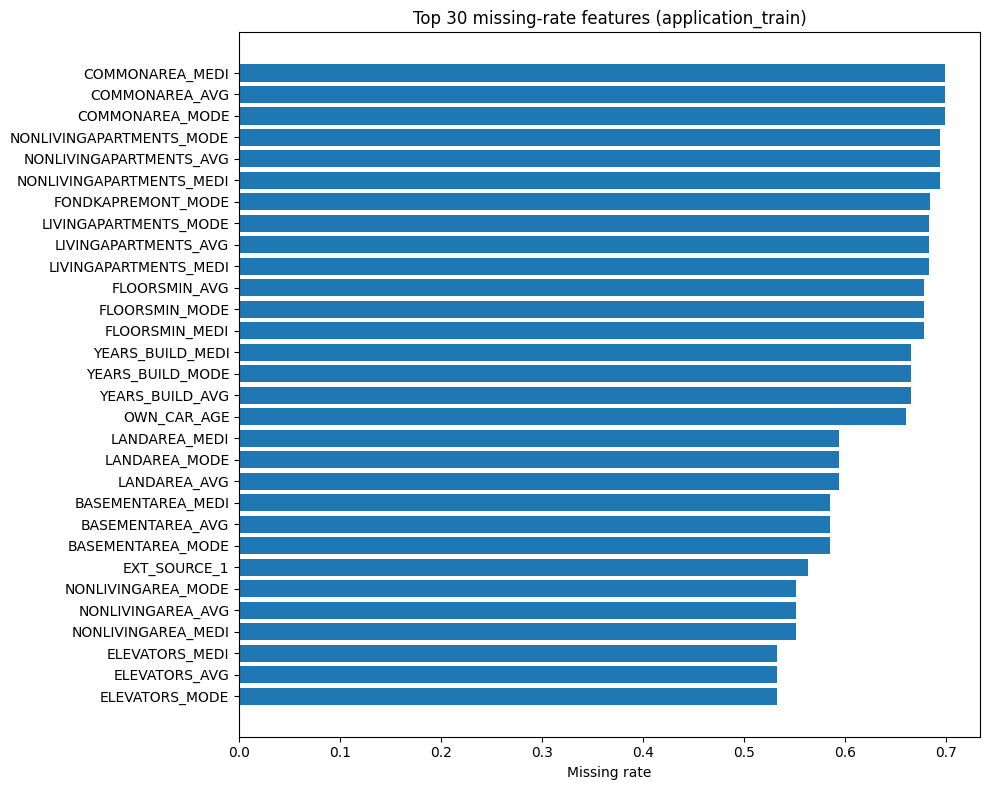

In [22]:
top_n = 30
to_plot = miss_app.head(top_n).iloc[::-1] 

plt.figure(figsize=(10, 8))
plt.barh(to_plot.index, to_plot["missing_rate"])
plt.xlabel("Missing rate")
plt.title(f"Top {top_n} missing-rate features (application_train)")
plt.tight_layout()
plt.show()

## Missing Values: Technical vs Business-driven

**Technical missing / placeholder values**
- Some variables contain encoded placeholder values (e.g., DAYS_EMPLOYED = 365243) indicating special statuses rather than real measurements.
- These should be transformed into NaN and/or accompanied by indicator flags.

**Business-driven missingness**
- Many housing-related attributes (e.g., COMMONAREA_*, LIVINGAPARTMENTS_*) show high missing rates.
- This missingness likely reflects absence of registered housing information or inapplicability, and may carry predictive signal.

In [29]:
issues_log = pd.DataFrame([
    {
        "table": "application_train",
        "field": "DAYS_EMPLOYED",
        "issue_type": "Technical placeholder",
        "symptom": "Value 365243 appears very frequently",
        "why_it_happens": "Known placeholder meaning 'no formal employment history'",
        "recommended_action": "Create flag (DAYS_EMPLOYED_PLACEHOLDER=1) and replace 365243 with NaN"
    },
    {
        "table": "application_train",
        "field": "COMMONAREA_*/LIVINGAPARTMENTS_* (and similar housing vars)",
        "issue_type": "Business-driven missingness",
        "symptom": "~70% missing",
        "why_it_happens": "Housing info not registered / not applicable for some applicants",
        "recommended_action": "Keep missing indicator; consider imputation + add is_missing flag"
    },
    
    {
            "table": "application_train",
            "field": "FLAG_DOCUMENT_* / FLAG_MOBIL / similar binary flags",
            "issue_type": "Highly imbalanced feature",
            "symptom": "Most frequent value accounts for >99% of observations",
            "why_it_happens": "Certain documents or attributes are rarely present in the applicant population",
            "recommended_action": "Keep for modeling; consider variance-based filtering if needed"
    }
]
)

issues_log

,table,field,issue_type,symptom,why_it_happens,recommended_action
0,application_train,DAYS_EMPLOYED,Technical placeholder,Value 365243 appears very frequently,Known placeholder meaning 'no formal employmen...,Create flag (DAYS_EMPLOYED_PLACEHOLDER=1) and ...
1,application_train,COMMONAREA_*/LIVINGAPARTMENTS_* (and similar h...,Business-driven missingness,~70% missing,Housing info not registered / not applicable f...,Keep missing indicator; consider imputation + ...
2,application_train,FLAG_DOCUMENT_* / FLAG_MOBIL / similar binary ...,Highly imbalanced feature,Most frequent value accounts for >99% of obser...,Certain documents or attributes are rarely pre...,Keep for modeling; consider variance-based fil...


In [30]:
issues_log.to_csv("../reports/data_issues_log_day2.csv", index=False)
print("Saved: ../reports/data_issues_log_day2.csv")

Saved: ../reports/data_issues_log_day2.csv
